In [1]:
#from utils2 import getSynteticData, exactTest, MWU, ttests, multiple_plot, getdf
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
import parallelPermutationTest as ppt
from plots import multiple_plot

In [2]:
%load_ext cython
%load_ext rpy2.ipython



In [3]:
%%capture
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

In [4]:
%%R
    runFastPerm <- function(x,y,output, n_samples) {
        e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


    }

In [5]:
def fastPerm(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runFastPerm(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

In [6]:
class calibration_experiment:
    def getSynteticData(self, func, setN=20, sampleN=2_000, mean=0, std=1,seed=1):
        """Generate synthetic data"""
        np.random.seed(seed)
        AN, BN = [func(mean,std,setN) for i in range(sampleN)], [func(0,std,setN) for i in range(sampleN)]
        return AN, BN

    def getdf(self, P, num_examples, test=None):
        P.sort()
        p_arr = np.array(P)
        offset = 1.0/float(num_examples)
        ideal_arr = np.linspace(offset,1.0-offset,num_examples)
        if test:
            Pdf = pd.DataFrame({'Observed p-value':p_arr,'Theoretical p-value':ideal_arr, "Test":[test]*ideal_arr.shape[0]})
        return Pdf
    
    def MWU(self, A, B, one_side=False):
        p_mw = list()
        for a,b in zip(A, B):
            if one_side:
                p_mw.append(mannwhitneyu(a,b, alternative="less")[1])
            else:
                p_mw.append(mannwhitneyu(a,b, alternative="two-sided")[1])
        return p_mw

    def ttests(self, A, B, one_side=False):
        p_t = list()
        for x, y in zip(A, B):
            t, p = ttest_ind(y, x)
            if one_side:
                p = p/2
                if t<0:
                    p = 1-p
            p_t.append(p)
        return p_t
    
    def getPrediction(self, A, B):
        Data = dict()
    
        Data["eList"] = ppt.GreenFloatCuda(np.array(A),np.array(B), 100, batch_size=int(np.array(A).shape[0]/3))
        Data["fpList"] = fastPerm(np.array(A),np.array(B))
        Data["mwuList"] = self.MWU(A, B, False)
        Data["ttList"] = self.ttests(A, B, False)
    
        Data["eVttDf"] = pd.DataFrame(data=
                                  {'Parallel Green': Data["eList"], 'Ttest': Data["ttList"] })
        Data["mwuVttDf"] = pd.DataFrame(data={'Mann–Whitney U-test': Data["mwuList"], 'Ttest': Data["ttList"]})
        Data["eVmwuDf"] = pd.DataFrame(data={'Parallel Green': Data["eList"], 'Mann–Whitney U-test': Data["mwuList"]})

        Data["eVfpDf"] = pd.DataFrame(data={'Parallel Green': Data["eList"], 'FastPerm': Data["fpList"]})
        Data["mwuVfpDf"] = pd.DataFrame(data={'Mann–Whitney U-test': Data["mwuList"], 'FastPerm': Data["fpList"]})
        Data["ttVfpDf"] = pd.DataFrame(data={'Ttest': Data["ttList"], 'FastPerm': Data["fpList"]})
                                                      
        return Data

    

    
    

In [7]:
exp = calibration_experiment()

# $A \sim N(0,1)\ and B \sim N(0,1)$. $ |A|=20$ and $|B|=20$ with $2000$ samples.

In [8]:
np.random.seed(10)
S = 20_000

In [12]:
AN, BN = exp.getSynteticData(np.random.normal,mean=0,sampleN=S)
%time DataNormNoDiff = exp.getPrediction(AN, BN)

CPU times: user 48min 43s, sys: 1.46 s, total: 48min 44s
Wall time: 48min 43s


In [13]:
normfpDf = exp.getdf(DataNormNoDiff["fpList"], S, "FastPerm")
normexactDf = exp.getdf(DataNormNoDiff["eList"], S, "Green")
normttDf = exp.getdf(DataNormNoDiff["ttList"], S, "$\it{T}$ test")
normmwuDf = exp.getdf(DataNormNoDiff["mwuList"], S, "Mann–Whitney $\it{U}$ test")

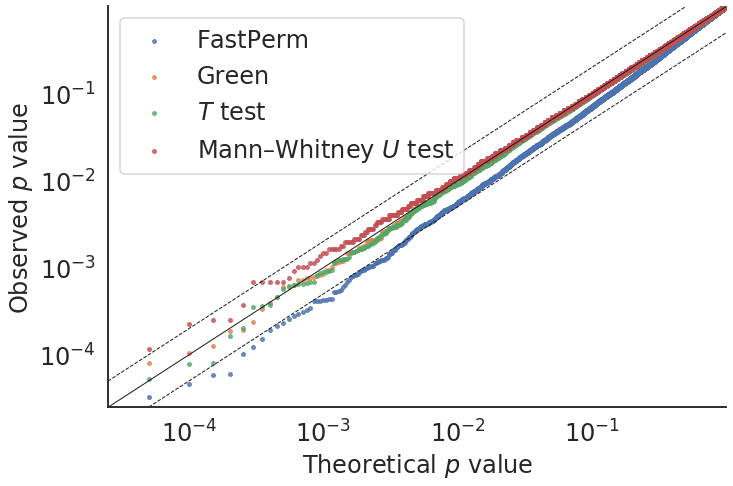

In [15]:
multiple_plot(pd.concat((normfpDf, normexactDf, normttDf, normmwuDf)), "figures/experiment5/allTests_0_1_50")
              
              

# $A \sim logN(0,1)\ and B \sim logN(0,1)$. $ |A|=20$ and $|B|=20$ with $2000$ samples.

In [16]:
AN, BN = exp.getSynteticData(np.random.lognormal, mean=0, sampleN=S)
DataLogNormNonDiff = exp.getPrediction(AN, BN)

In [17]:
logfpDf = exp.getdf(DataLogNormNonDiff["fpList"], S, "FastPerm")
logexactDf = exp.getdf(DataLogNormNonDiff["eList"], S, "Green")
logttDf = exp.getdf(DataLogNormNonDiff["ttList"], S, "$\it{T}$ test")
logmwuDf = exp.getdf(DataLogNormNonDiff["mwuList"], S, "Mann–Whitney $\it{U}$ test")

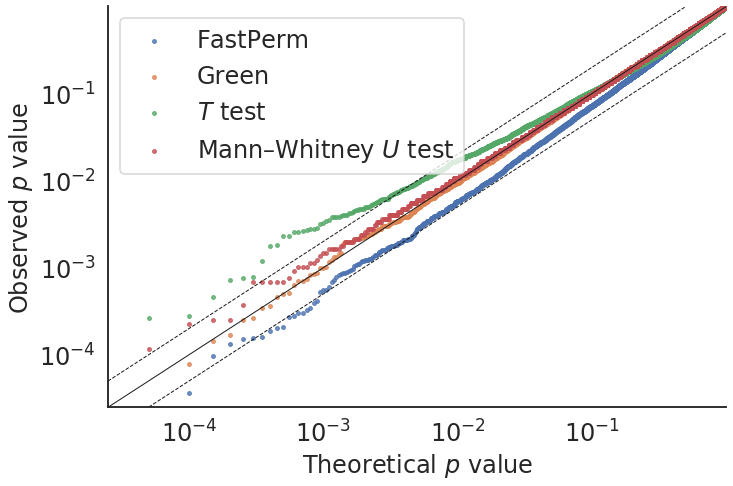

In [18]:
multiple_plot(pd.concat((logfpDf, logexactDf, logttDf, logmwuDf)), "figures/experiment5/allTestsLog_0_1_50")
